## Who owns Lausanne? 
Introductory Jupyter Notebook.

### Introduction
#### Public data
We obtained ftp access from the Lausanne office of cadastre. The data is a collection of ESRI shapefiles, describing roads, buildings, parcels, trees, waterbodies, and others.
Each shapefile is a collection of features, and each feature has an associated geometry (e.g. the shape of a land parcel) and associated attributes ( e.g. the commune responsible for the parcel, the parcel number).

We can explore this dataset by using GIS software that supports shapefiles. We used QGIS to explore the dataset.
We hoped to find an attribute describing the parcel owner in the parcel shapefile layer, but it wasn't there.
We had to resort to web scraping to recover this attribute.

## 1. Owner scraping

### 1.1 Download XML files
We wanted to associate each parcel in Lausanne to an owner. To do this, we divided Lausanne's surface in rectangles, and requested parcel informations for these rectangles to a service exposing the owners name.
The code for the scraping is in [`/scraping/owners/scrape_owners_to_xml.py`](/edit/scraping/owners/scrape_owners_to_xml.py).

The result of owner scraping is a set of 400 xml files, each containing parcel information for a geographical rectangle. The data are saved in the following directory: `data/raw/owners/`

For privacy reason we decided not to push any data on the online github respository.

We start exploring the raw owner xml data:

In [1]:
!ls "data/raw/owners/" | wc -l

       0


Each file is named after the coordinates, in the Swiss systems, of the top-left and bottom-right points bounding the scraped rectangle.

In [2]:
!ls "scraped" 2>/dev/null | head -10 # suppress error message by redirecting errors to null

In [3]:
!head -n 20 "scraped/534810.4210526316_155847.0_535161.3710526315_155589.0.xml"

head: scraped/534810.4210526316_155847.0_535161.3710526315_155589.0.xml: No such file or directory


### 1.2 From XML to a single JSON
We use the `xq` and `jq` programs to extract only the features we care about from the differents XML files and save them as a list of objects in a single json file.
[`scraping/owners/multiple_xml_to_single_json.sh`](/edit/scraping/owners/multiple_xml_to_single_json.sh) is a small script leveraging the expressiveness of `jq` to efficiently concatenate the XML files into a single json, while also discarding all the attributes we have no interest in.

### 1.3 Remove duplicated and  clean owners JSON
The generated `proprio.json` JSON has duplicate entries, entries concerning other communes than lausanne and entries with missing owners. Furthermore, JSON is not the best format to handle tabluar data. The code in [`scraping/owners/owner_json_to_clean_csv.py`](/edit/scraping/owners/owner_json_to_clean_csv.py) clean the duplicates and tranfsorm the data in  CSV files.

### 1.4 Joining the owners data with the cadastre shapefiles
The result of the previous preprocessing steps is a CSV file with three columns: `commune number`, `parcel number`, and `owner name`:

In [4]:
# TODO PIETRO ADD 

# READ 'proprio lausanne' CSV
# SHOW HEAD + COLUMNS

We would like to add the owner name to the attributes of the parcels shapefile that we obtained from "Office du Cadastre". To do so, we import the csv and the shapefile in QGIS, and we join this two "tables" by parcel number. The resulting geographical layer contains all the geographical features representing the parcels, and additionally the owner name for each parcel. We can now export this layer as a GeoJSON, making sure of using WGS-84 as the coordinate system,  and continue our exploration in a jupyter notebook:

## 2. Cadastral data - data exploration

We now have a GeoJSON, containing parcel geometries and parcel owners.

In [5]:
#imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import folium

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [6]:
with open('data/owners/parcelles_wgs84.geojson') as geojson:
    geo = json.load(geojson)

In [7]:
# geo.features contains the list of parcelles
# example:
geo['features'][0]

{'geometry': {'coordinates': [[[[6.649243673017351, 46.53188951389799],
     [6.649523668447272, 46.53193392291745],
     [6.649614828833634, 46.53195758677332],
     [6.649625950178285, 46.5319368832331],
     [6.649790291604392, 46.53202825631578],
     [6.650003979051746, 46.53218609311889],
     [6.650047998245191, 46.53226025663983],
     [6.650054485340016, 46.53227127690713],
     [6.650058311996016, 46.53225915883489],
     [6.650088428254771, 46.53217840368877],
     [6.650111221395856, 46.532117119071344],
     [6.650106761663261, 46.532074356839374],
     [6.65000712824151, 46.5320953448597],
     [6.649800000361972, 46.53194358101801],
     [6.649722459944011, 46.53189770180645],
     [6.649629255922862, 46.53186223899871],
     [6.649655800976412, 46.53185648619317],
     [6.649336305928722, 46.53181234248936],
     [6.649272844818175, 46.5318020953107],
     [6.649243673017351, 46.53188951389799]]]],
  'type': 'MultiPolygon'},
 'properties': {'EGRID': 582083457612,
  'GID

We load the attributes of each geographical features in Pandas:

In [8]:
features = [
    {'parc_num':feature['properties']['NO_PARC'],
    'owner':feature['properties']['proprio']} for feature in geo['features']
]
parcels = pd.DataFrame.from_records(features)
parcels.head()

,owner,parc_num
0,Viertl Jacqueline,3479
1,Bütikofer Serge / Fernandes de Oliveira Olivia,3478
2,PPE parcelles 3476-1 à 3476-6,3476
3,PPE parcelles 10004-1 à 10004-9,10004
4,Porta Olivier / von Ritter-Zahony Marc,10020


## 2.1 Who is the biggest real estate owners?

We can now quickly answer questions such as who are the 30 biggest property owners in Lausanne, by using the number of parcels owned as to measure "bigness":

In [9]:
parcels_per_owner = parcels['owner'].value_counts()
parcels_per_owner.head(30)

Commune de Lausanne                                                           1265
Caisse de Pensions du Personnel Communal  (CPCL)                               106
CPEV - Caisse de Pensions de l'Etat de Vaud                                     83
Swiss Life SA                                                                   68
Etat de Vaud - DFIRE - Service immeubles, patrimoine et logistique (SIPAL)      59
FIR VD SA                                                                       50
LA FONCIERE LSNE SA                                                             44
Solvalor fund management S.A.                                                   41
Retraites Populaires                                                            38
Bâloise Vie SA                                                                  36
SCHL - Société Coopérative d'habitation Lausanne                                34
LO Immeubles S.A.                                                               34
AXA 

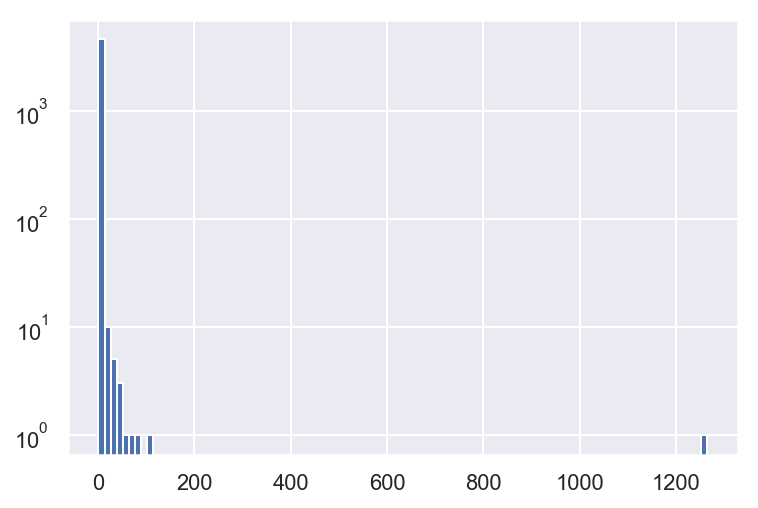

In [10]:
plt.hist(parcels_per_owner.values, log=True, bins=100);

## 2.2 PPE: Propriété par étages (Owners by floor)

Some building have more than one owners. Often, different floor of the same house is owned by different owners:

In [11]:
# Check portion of parcels owned by PPE
parcels['owner'].astype('str').str.contains('PPE').mean()

0.07971784713498889

Around 8% of parecels are owned by owners by floor. 

## 2.3 Unique owners

In [12]:
owners = parcels['owner'].dropna()
print('total parcels', len(owners))
print('unique owners', len(owners.unique()))

total parcels 7976
unique owners 4628


There are 8k parcels in Lausanne. We are interestd to know how many people/societies own them. This number doesn't account for PPE. A lower bound on the owners can be estimated by discarding PPE all-together.

In [13]:
len(owners[~owners.str.contains('PPE ')].unique())

3804

This is a lower bound for the number of owners, although the real number is likely to be much higher since it's unlikely that all of these owners are also owners of every PPE share.

## 2.4 Counting the number of PPE shares
With Propriété par étage, each building is divided in several shares, and has multiple owners. We don't have the owners for the PPE, but we can estimate the total number of PPE shares. An upper bound for the number of owners would be attributing a distinct owner to every PPE share.

In [14]:
owners[owners.str.contains('PPE ')].head(10)

2               PPE parcelles 3476-1 à 3476-6
3             PPE parcelles 10004-1 à 10004-9
5                 PPE parcelles 10268 à 10275
28                PPE parcelles 16584 à 16609
36                  PPE parcelles 8435 à 8442
41                PPE parcelles 16835 à 16845
51                PPE parcelles 11803 à 11815
57                PPE parcelles 13801 à 13812
80              PPE parcelles 5254-1 à 5254-5
98    PPE parcelles 7502 à 7512, 20561, 20562
Name: owner, dtype: object

We can see that PPE information is formatted in several ways:

- ranges where the first number is fixed, and a suffix is added for each share: `PPE parcelles 3476-1 à 3476-6`
- ranges where the number represent the PPE share identifier: `PPE parcelles 16584 à 16609`
- ranges mixed with single values: `PPE parcelles 7502 à 7512, 20561, 20562`

Parsing this values is not particularly challenging but it is boring, I'll think of it another time **TODO**.

### 2.5 Visualizing the distribution of missing values

In [15]:
# Compute portion of missing values
parcels['owner'].isna().mean()

0.22929751666827713

22% of the parcels don't have owner information. Indeed, many parcels reperesent roads, and as such they didn't have an owner on the site we scraped. Also we didn't scrape the values for the northern part of Lausanne, which is mostly farmland and woods.
Let's try to visualize the missing values on a map:

In [16]:
# TODO: show maps of missing values
import folium
def getMap():
    return folium.Map([46.55, 6.63], tiles='cartodbpositron', zoom_start=13)

In [17]:
map = getMap()

def style_function(feature):
    return {
        'fillColor':
            'red' if feature['properties']['proprio'] is None\
            else 'blue', #red for missing value, blue for valid
        'stroke': False
    }

geo_fol = folium.GeoJson(geo, style_function=style_function)

map.add_child(geo_fol)
map

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


This visualization is not very snappy or legible, but we can interpret it as follow:

- Red areas are parcels for which the proprietary is `None`. The northern parts of Lausanne were not scraped, since we didn't want to overload the scraped website and anyway they're mostly rural. So it is expected that they are red.
- Zooming into central Lausanne, we see that roads have unknown owners. This is also expected.
- Some areas are an overlap of Blue and Red, yielding purple parcels. This is because the dataset is slightly dirty, and some bigger parcels with no owner contain in their surface smaller parcels with known owners.

Having asserted that the dataset is fairly sane, we can drop the features were owner is `None`, since they will be of no use to us, and will make map drawing slower.

In [18]:
geo_clean = geo.copy()

In [19]:
geo_clean['features'] =\
    [feature for feature in geo['features']
     if feature['properties']['proprio'] is not None]

In [20]:
len(geo_clean['features']), len(geo['features'])

(7976, 10349)

## Show parcels by owner type

In [21]:
def categorize(owner):
    if owner is None:
        return None
    owner = owner.lower()
    
    if owner == 'commune de lausanne' or\
        'dfire' in owner or\
        'cff' in owner:
        return 'public'
    elif 'retraites' in owner or\
        'pensions' in owner or\
        'prévoyance' in owner:
        return 'pension'
    elif 'fondation' in owner:
        return 'foundation'
    elif ' s.a.' in owner or\
        ' sa' in owner or\
        ' ag' in owner or\
        'société anonyme' in owner:
        return 'AG'
    elif 'ppe ' in owner or\
        'copropriété' in owner:
        return 'PPE'
    elif 'société coopérative' in owner:
        return 'coop'
    else:
        return 'private' #not true but let's approximate

In [22]:
owners_categories = owners.to_frame()
owners_categories['category'] = owners.apply(categorize)
owners_categories = owners_categories.drop_duplicates().set_index('owner')

In [23]:
map = getMap()

def style_function(feature):
    colors = {
        'coop': 'yellow',
        'AG' : 'red',
        'public' : 'green',
        'private': 'blue',
        'PPE': 'orange',
        'pension': 'purple',
        'foundation' : 'brown'
        
    }
    owner = feature['properties']['proprio']
    cat = owners_categories.loc[owner][0]
    
    return {
        'stroke':False,
        'fillColor': colors[cat]
    }

folium.GeoJson(geo_clean, style_function=style_function, tooltip=folium.GeoJsonTooltip(['proprio'])).add_to(map)
map

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# TODO

- more robust categorizing, maybe use https://www.zefix.admin.ch
- find habitable volume for each parcel 

# Questions

- How to use Folium without an internet connection?